# Intro

In this example from _Hands-On Machine Learning with Scikit-learn, Keras & TensorFlow_ by Aurelien Geron, we will use the California Housing Prices dataset from StatLib. <br>
This dataset is based on data from the 1990 California census.

The data we will use includes metrics such as population, median income, median housing price etc. We will try to predict the median housing price for each block group / district in California. 

### 1. First, let's decide what kind of task we have on our hands

This is a typical supervised learning task, as we will use labeled examples (each instance comes with an expected output - the median house pricing). It is also a typical regression task since we want to predict a value. More specifically, this is a _multiple regression_ problem, since we will use several features to make a prediction. It is also a _univariate regression_ problem, as we want to predict a single value for each entry.

If we think about it in more mathematical terms, then we can associate our model with the following function:
$$
f : A \rightarrow B
$$
where $A$ is the set that contains features and $B$ is a set that contains targets.<br>
So, in our case, $f$ takes several variables and outputs a single one:
$$
f(x_1, x_2, ...) = y
$$
This is why we have a _multiple univariate_ regression task.<br>
If $dim(A) = 1$ then the problem would have been a _simple_ regression one. If $dim(B) > 1$ then it would have been a _multivariate_ regression task.

### 2. Now, let's select a performance measure

In regression problems we usually use the _root mean square error_ (RMSE). It gives us an idea of how much error the system typically makes in its predictions.

$$
RMSE(X, h) = \sqrt{\frac{1}{m}\sum_{i=1}^{m}(h(x^{(i)}) - y^{(i)})^2}
$$

- $m$ - the number of instances/entries in the dataset

- $x^{(i)}$ - the vector of all feature values (excluding the label or target) of the $i^{th}$ instance in the dataset

- $y^{i}$ - the label corresponding to the $i^{th}$ vector of features

- $X$ - the matrix containing all the feature values of all the entries in the dataset. It has the following structure:
$$
X = 
\begin{pmatrix}
(x^{(1)})^T \\
(x^{(2)})^T \\
... \\ \\
(x^{(m)})^T
\end{pmatrix}
$$

- $h$ - the system's prediction fucntion, also called a _hypothesis_ (or estimators). When the system receives an instance's feature vector $x^{(i)}$, it outputs a predicted value $\hat{y}^{(i)} = h(x^{(i)})$

- $RMSE(x, h)$ - the **cost** function measured on the set of examples using the hypothesis $h$

### 3. Coding time!

First of all, let's load the data we'll work with:

In [67]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

In [68]:
def load_housing_data():
    tar_path = Path("datasets/housing.tgz")
    if not tar_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tar_path)
        with tarfile.open(tar_path) as housing_tar:
            housing_tar.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

In [69]:
housing = load_housing_data()

^ when `load_housing_data()` is called, it looks for _datasets/housing.tgz_. If it does not find it, it creates the _datasets_ directory, downloads _housing.tgz_ and extracts its content in the _datasets_ directory. Then we use pandas to read from the .csv file inside it.

In [70]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [71]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


^ There are 20,640 entries in the dataset (so it's a fairly small one by ML standards). <br>
An important thing to notice is that the `total_bedrooms` attribute has only 20,433 non-null values, meaning that there are districts missing this feature. We will take care of this a bit later.

In [72]:
housing.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


In [73]:
import matplotlib.pyplot as plt

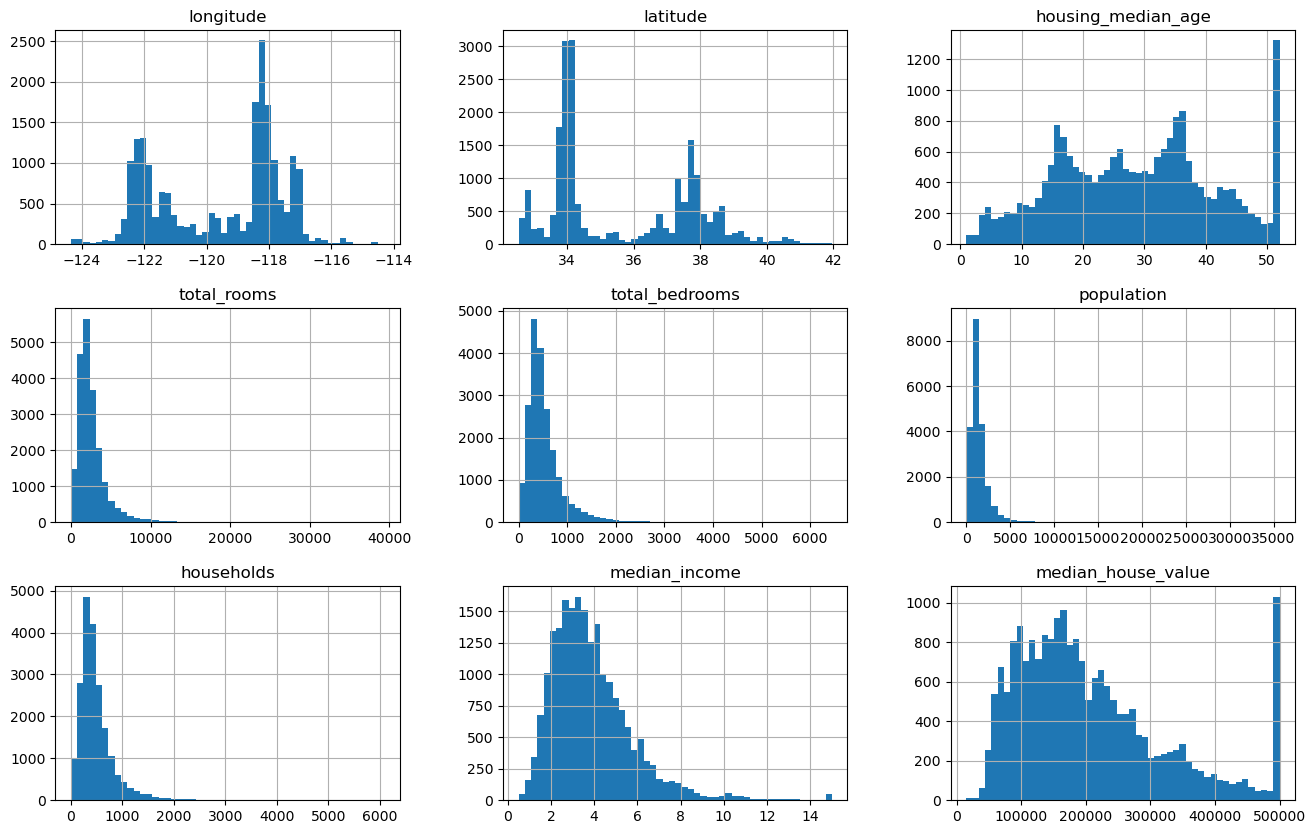

In [74]:
housing.hist(bins=50, figsize=(16, 10))
plt.show()

Looking at the plotted histograms, we can notice a few things:
- the `median_income` attribute is not expressed in USD, but in tens of thousands of dollars (so 3 means $30,000). 

- the `median_income` is capped at 0.5 and 15.

- `housing_median_age` and `median_house_value` are also capped. This can be a serious problem because `median_house_value` is our target attribute. our ML model may learn that house prices never go beyound the cap value. We will need to either ask for proper label/target collection without the value cap or remove those districts from the training and test sets. 

- all these attributes have very different scales.

- many histograms are _skewed right_: they extend much farther to the right of the median that to the left. This may make it harder for ML algorithms to detect patterns. 

We will tackle these issues a bit later.

Now we need to create a test set. That may seem simple - just pick some random entries, 20% of the dataset, and set them aside:

In [75]:
import numpy as np

In [76]:
def shuffle_and_split(data, ratio):
    shuffled_indxs = np.random.permutation(len(data))
    testset_size = int(len(data) * ratio)
    test_indxs = shuffled_indxs[:testset_size]
    train_indxs = shuffled_indxs[testset_size:]
    return data.iloc[train_indxs], data.iloc[test_indxs]

In [77]:
# We can now use the function like this:
trainset, testset = shuffle_and_split(housing, 0.2)

^ This works, but there is a problem: if you re-run the code, it will generate a different test set. Over time, our ML algorithm will get to see the whole dataset, whish is something we want to avoid.

One possible solution is to save the test set on the first run by setting the random number generator's seed.

However, both these solutions will break the next time we fetch an updated dataset. A better option would be to use each instance's identifier to decide whether or not it goes in the test set. 

For example, we could compute a hash of each instance's identifier and put that instance in the test set if the hash is lower than or equal to 20% of the maximum hash value. This ensures that the test set will remain consistent across multiple runs, even with a refreshed dataset:

In [78]:
from zlib import crc32

def is_in_testset(id, ratio):
    return crc32(np.int64(id)) < ratio * 2**32

def split_data_with_hash(data, ratio, idcol):
    ids = data[idcol]
    in_testset = ids.apply(lambda id_: is_in_testset(id_, ratio))
    return data.loc[~in_testset], data.loc[in_testset]

# unfortunately for us, this dataset does not have an ID column. The simples solution is to just use the row index as the ID.

housing_wid = housing.reset_index()
trainset, testset = split_data_with_hash(housing_wid, 0.2, "index")

^ if we're going to use the row index as a unique ID, we need to make sure that new data always gets appended to the end of the dataset. This is not always possible, so we can insteead use the most stable features to build a unique identifier.

For example, a district's latitude and longitude are guaranteed to stay the same (at least for the next few million years), so we will combine them to form an ID:

In [79]:
housing_wid["id"] = housing["longitude"] * 1000 + housing["latitude"]
trainset, testset = split_data_with_hash(housing_wid, 0.2, "id")

Alternatively, we could also use **Scikit-Learn**:

In [80]:
from sklearn.model_selection import train_test_split

trainset, testset = train_test_split(housing, test_size=0.2, random_state=42)

So far we have considered using purely _random sampling_ methods. This is fine if the dataset os very large, but it can sometimes introduce a _sampling bias_. 

A better way is to use _stratified sampling_: the dataset is divided into homogenous subgroups called _strata_. The right number of entries is sampled from each stratum in order to guarantee that the test set is representative of the data.

Suppose some experts told us that the median income is a very important attribute for predicting median housing prices. We thus want to ensure that the test set is representative of the various categories of income in the whole dataset.

Since the median income is a continuous numerical attribute, we need to create an income category feature.

After looking at the `median_income` histogram we can see that most values are clustered around 1.5 to 6 ($15,000 - $60,000), but some values go far beyond 6. It is important to have a sufficient number of entries from each stratum, or else the estimate of a stratum's importance may be biased. 

In [81]:
housing["income_ctg"] = pd.cut(housing["median_income"], bins=[0.0, 1.5, 4.0, 4.5, 6.0, np.inf], labels=[1, 2, 3, 4, 5])

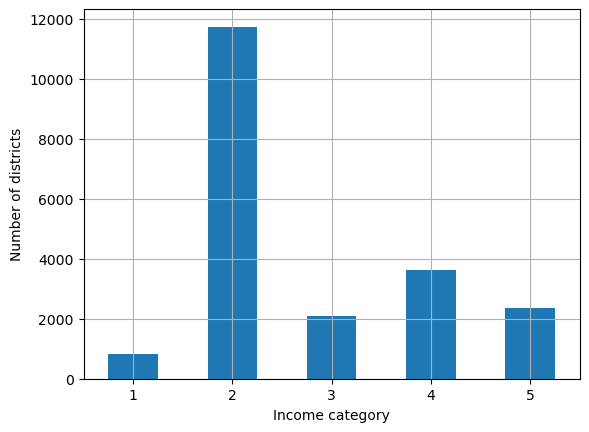

In [82]:
housing["income_ctg"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [85]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_ctg"]):
    strat_trainset_n = housing.iloc[train_index]
    strat_testset_n = housing.iloc[test_index]
    strat_splits.append([strat_trainset_n, strat_testset_n])

strat_trainset, strat_testset = strat_splits[0]

# alternatively, we can just use this for stratified sampling:

strat_trainset, strat_testset = train_test_split(housing, test_size=0.2, stratify=housing["income_ctg"], random_state=42)

In [93]:
print(strat_testset["income_ctg"].value_counts() / len(strat_testset))
print(housing["income_ctg"].value_counts() / len(housing))

income_ctg
2    0.568314
4    0.176357
5    0.114341
3    0.101017
1    0.039971
Name: count, dtype: float64
income_ctg
2    0.568362
4    0.176308
5    0.114438
3    0.101066
1    0.039826
Name: count, dtype: float64


^ as you can see the stratified sample has almost identical proportions to the original dataset.

We won't be using the `income_ctg` column again so we'll just drop it now, reverting the data to its original state:

In [ ]:
for set_ in (strat_trainset, strat_testset):
    set_.drop("income_cat", axis=1, inplace=True)